# 1. Import Libraries

In [1]:
!pip install contractions
!pip install wordcloud

In [2]:
#import praw
import pandas as pd
import os
import re
import requests
import time
import pickle
import calendar
import datetime as dt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#Display every call in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tqdm import tqdm
tqdm.pandas()
from langdetect import detect
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
import spacy
spacy.cli.download('en_core_web_sm')
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
import wordcloud
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vraci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vraci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
df = pd.read_csv('data/bitcoin_reddit_all.csv')

C:\Users\katap\AppData\Local\Temp\ipykernel_8640\2778878400.py:1: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/bitcoin_reddit_all.csv')


In [4]:
# Save the reddit data
pickle_out=open('data/reddit_raw.pkl','wb')
pickle.dump(df, pickle_out)
pickle_out.close()

# Create the corpus

In [5]:
# Load the topics dictionary
pickle_in=open('data/reddit_raw.pkl','rb')
reddit_raw=pickle.load(pickle_in)
pickle_in.close()

In [6]:
# Clean the text
def clean_text(raw_string):
    # remove emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    cleaned_string = emoji_pattern.sub(r'', raw_string)
    # remove urls
    cleaned_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', cleaned_string)
    cleaned_string = re.sub(r'(www.{2,100}\b)', '', cleaned_string)
    # remove special characters
    cleaned_string = re.sub("[^A-Za-zșȘȚțÎîÂâĂă.,:!?\- ]", " ", cleaned_string, re.I)
    # remove multiple spaces
    cleaned_string = re.sub(' +', ' ', cleaned_string)
    return cleaned_string

In [7]:
reddit_raw.head(5)

Unnamed: 0             datetime        date           author  subreddit  \
0          0  2014-06-26 16:49:41  2014-06-26      HonorConnor  AskReddit   
1          1  2014-05-17 23:30:36  2014-05-17         Talvoren  AskReddit   
2          2  2014-12-18 04:54:48  2014-12-18         ninjoe87   Outdoors   
3          3  2014-04-30 00:24:16  2014-04-30  fathergrigori54        tf2   
4          4  2014-07-07 16:06:21  2014-07-07      Draber-Bien  starcraft   

    created_utc  score  controversiality  \
0  1.403801e+09  162.0               0.0   
1  1.400369e+09   75.0               0.0   
2  1.418878e+09   -4.0               0.0   
3  1.398817e+09   13.0               0.0   
4  1.404749e+09   19.0               0.0   

                                                body  
0  How do you feel about Bitcoin? I don't really ...  
1  [The guy who blew a huge portion of his and hi...  
2  Because you are a damn liar.\n\nFrom my other ...  
3  This was the bitcoin hat guy that ACTUALLY del...  
4                I'm sure this is *good* for bitcoin

In [8]:
#Tranform body in str
reddit_raw["body"]= reddit_raw["body"].astype(str)

In [9]:
reddit_corpus = pd.DataFrame(reddit_raw)
reddit_corpus["body"] = reddit_corpus["body"].progress_apply(lambda x: clean_text(x))
reddit_corpus.head(2)

100%|██████████| 4309244/4309244 [02:46<00:00, 25880.14it/s] 


Unnamed: 0             datetime        date       author  subreddit  \
0          0  2014-06-26 16:49:41  2014-06-26  HonorConnor  AskReddit   
1          1  2014-05-17 23:30:36  2014-05-17     Talvoren  AskReddit   

    created_utc  score  controversiality  \
0  1.403801e+09  162.0               0.0   
1  1.400369e+09   75.0               0.0   

                                                body  
0  How do you feel about Bitcoin? I don t really ...  
1   The guy who blew a huge portion of his and hi...

In [10]:
reddit_corpus.dtypes

Unnamed: 0           object
datetime             object
date                 object
author               object
subreddit            object
created_utc         float64
score               float64
controversiality    float64
body                 object
dtype: object

In [11]:
# Save the reddit data
pickle_out=open('data/reddit_clean.pkl','wb')
pickle.dump(reddit_corpus, pickle_out)
pickle_out.close()

In [12]:
# Load the topics dictionary
pickle_in=open('data/reddit_clean.pkl','rb')
reddit_corpus=pickle.load(pickle_in)
pickle_in.close()

# Transform the time column in a datetime format

In [13]:
# Trasnform the time column in a UTC timestamp
#def get_date(time):
    #return dt.datetime.fromtimestamp(time)

In [14]:
#_timestamp = reddit_corpus["datetime"].progress_apply(get_date)
#reddit_corpus = reddit_corpus.assign(datetime = _timestamp)
#reddit_corpus.head(2)

In [15]:
reddit_corpus['datetime'] = pd.to_datetime(reddit_corpus['datetime'], errors='coerce')

In [16]:
min(reddit_corpus["datetime"])

Timestamp('2009-05-08 13:54:29')

In [17]:
max(reddit_corpus["datetime"])


Timestamp('2019-12-31 23:58:38')

In [18]:
# Convert timestamp to date
def dt(x):
    t = pd.Timestamp(x)
    return pd.Timestamp.date(t)

In [19]:
reddit_corpus['date'] = reddit_corpus['date'].progress_apply(dt)

100%|██████████| 4309244/4309244 [00:09<00:00, 435866.80it/s]


In [20]:
# Set start date of tweets
#reddit_corpus = reddit_corpus[reddit_corpus['date'] >= datetime.date(2019, 10, 1)]
reddit_corpus = reddit_corpus[reddit_corpus['date'] >= datetime.date(2019, 1, 1)]


In [21]:
# Set end date of tweets
#reddit_corpus = reddit_corpus[reddit_corpus['date'] <= datetime.date(2019, 12, 31)]
reddit_corpus = reddit_corpus[reddit_corpus['date'] <= datetime.date(2019, 9, 30)]


In [22]:
len(reddit_corpus["body"])

391057

In [23]:
# Check reddit language
def detect_lang(text):
    try:
        lang = detect(text)
    except:
        lang = 'Other'
    return lang

In [24]:
reddit_corpus['language'] = reddit_corpus['body'].progress_apply(lambda x: detect_lang(x))

100%|██████████| 391057/391057 [14:57<00:00, 435.49it/s]


In [25]:
reddit_corpus = reddit_corpus[reddit_corpus['language'] == 'en']

In [26]:
len(reddit_corpus["body"])

384068

# Compute the number of words in text

In [27]:
reddit_corpus['word_len_body'] = reddit_corpus['body'].progress_apply(lambda x: len(word_tokenize(x)))

100%|██████████| 384068/384068 [02:18<00:00, 2777.39it/s]


In [28]:
reddit_corpus.head(2)

Unnamed: 0            datetime        date        author subreddit  \
3816338    3700455 2019-09-28 00:38:16  2019-09-28      Anenome5       btc   
3816339    3700456 2019-09-04 00:45:54  2019-09-04  fallleaves14       btc   

          created_utc  score  controversiality  \
3816338  1.569631e+09   23.0               0.0   
3816339  1.567558e+09  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body  
3816338            246  
3816339             65

In [29]:
# Total number of words in bodies
reddit_corpus["word_len_body"].sum(axis=0)

36786994

# Save the dataframe corpus

In [30]:
reddit_corpus.to_csv(os.path.join("data", "reddit_corpus.csv"), index=False)

# done with get data

# Start Cleaning process

# Missing value

In [31]:
reddit_corpus.info() # missing value check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384068 entries, 3816338 to 4309243
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        384068 non-null  object        
 1   datetime          384068 non-null  datetime64[ns]
 2   date              384068 non-null  object        
 3   author            384068 non-null  object        
 4   subreddit         384068 non-null  object        
 5   created_utc       384068 non-null  float64       
 6   score             384068 non-null  float64       
 7   controversiality  384068 non-null  float64       
 8   body              384068 non-null  object        
 9   language          384068 non-null  object        
 10  word_len_body     384068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 35.2+ MB


In [32]:
reddit_corpus.isna().any() #MISSING VALUE

Unnamed: 0          False
datetime            False
date                False
author              False
subreddit           False
created_utc         False
score               False
controversiality    False
body                False
language            False
word_len_body       False
dtype: bool

In [33]:
reddit_corpus.head(2)

Unnamed: 0            datetime        date        author subreddit  \
3816338    3700455 2019-09-28 00:38:16  2019-09-28      Anenome5       btc   
3816339    3700456 2019-09-04 00:45:54  2019-09-04  fallleaves14       btc   

          created_utc  score  controversiality  \
3816338  1.569631e+09   23.0               0.0   
3816339  1.567558e+09  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body  
3816338            246  
3816339             65

# Drop unnecessary columns

In [34]:
reddit_corpus = reddit_corpus.drop(columns = ["Unnamed: 0", "author", "created_utc"])
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
3816338 2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
3816339 2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body  
3816338            246  
3816339             65

# Preprocess data

In [35]:
# Check data types in corpus
reddit_corpus.dtypes

datetime            datetime64[ns]
date                        object
subreddit                   object
score                      float64
controversiality           float64
body                        object
language                    object
word_len_body                int64
dtype: object

In [36]:
# # Transform data types to strings for easy management
reddit_corpus['body'] = reddit_corpus['body'].astype(str)

In [37]:
sub_reddit_com_number = reddit_corpus.groupby(['subreddit']).size() # group by
#x = x.to_frame()
sub_reddit_com_number

subreddit
0b0t          2
0chain        1
0xProject    10
0xbitcoin     7
11foot8       1
             ..
zines         1
zksharks      5
zrxtrader    42
zurich        8
zycrypto      1
Length: 7135, dtype: int64

In [38]:
# Plot the frequency of comments numbers
figure(num= None, figsize = (20,18),dpi=512)
fig = sub_reddit_com_number.value_counts().sort_index().plot(kind='bar')
fig.set_title('Comments number frequency')
fig.set_xlabel('Number of comments')
fig.set_ylabel('Frequency')
plt.show()

<Figure size 10240x9216 with 0 Axes>

Text(0.5, 1.0, 'Comments number frequency')

Text(0.5, 0, 'Number of comments')

Text(0, 0.5, 'Frequency')

In [39]:
figure(num= None, figsize = (20,18),dpi=512)
fig = reddit_corpus['word_len_body'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of number of words in body')
fig.set_xlabel('Number of words in body')
fig.set_ylabel('Frequency')
plt.show()

<Figure size 10240x9216 with 0 Axes>

Text(0.5, 1.0, 'Frequency of number of words in body')

Text(0.5, 0, 'Number of words in body')

Text(0, 0.5, 'Frequency')

In [40]:
# Preprocess the posts text in corpus
def preprocess(document):
    document = str(document)
    # Contractions
    document = contractions.fix(document)
    # Lowercasing
    document = document.lower()
    # Remove any whitespaces
    document = re.sub(r'[^\w\s]', ' ', document)
    document = re.sub(r'[^a-z ]', '', document)
    # Word Tokenize
    document = word_tokenize(document)
    # Stopwords
    stop_words = stopwords.words('english')
    document = [word for word in document if word not in stop_words]
    # Lemmatizer
    document = ' '.join(document)
    document = [word.lemma_ for word in nlp(document)]
    # Change the output to a sentence
    document = ' '.join(document)

    return document

In [41]:
reddit_corpus['posts_body'] = [preprocess(document) for document in reddit_corpus['body'].to_list()]
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
3816338 2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
3816339 2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body                                         posts_body  
3816338            246  look lightning payment work similar iou bearer...  
3816339             65  gt blockstream core devs well yeah lie bcasher...

In [42]:
# Save the corpus insv
reddit_corpus.to_csv(os.path.join("data", "reddit_corpus_cleaned.csv"), index=False)

# Bag of words top 5000 - changed to 7000 after expanding time interval

In [43]:
corpus_posts = reddit_corpus['posts_body']

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
# Create dtm (document term matrix) for most frequent 5000 words
vec_bodys = CountVectorizer(max_features=7000)
counts_per_body = vec_bodys.fit_transform(corpus_posts)
counts_per_body

<384068x7000 sparse matrix of type '<class 'numpy.int64'>'
	with 11712489 stored elements in Compressed Sparse Row format>

In [46]:
posts_words = vec_bodys.get_feature_names()
posts_words[1700]

C:\Users\katap\.virtualenvs\workspace\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'design'

In [47]:
dtm_posts = pd.DataFrame(counts_per_body.toarray(), columns = posts_words)
dtm_posts.head(6)

aa  ab  abandon  abc  abide  ability  able  abolish  abra  abroad  ...  \
0   0   0        0    0      0        0     1        0     0       0  ...   
1   0   0        0    0      0        0     0        0     0       0  ...   
2   0   0        0    0      0        0     0        0     0       0  ...   
3   0   0        0    0      0        0     0        0     0       0  ...   
4   0   0        0    0      0        0     0        0     0       0  ...   
5   0   0        0    0      0        0     0        0     0       0  ...   

   zec  zelle  zero  zimbabwe  zk  zombie  zone  zoom  zuck  zuckerberg  
0    0      0     0         0   0       0     0     0     0           0  
1    0      0     1         0   0       0     0     0     0           0  
2    0      0     0         0   0       0     0     0     0           0  
3    0      0     0         0   0       0     0     0     0           0  
4    0      0     0         0   0       0     0     0     0           0  
5    0      0     0         0   0       0     0     0     0           0  

[6 rows x 7000 columns]

In [48]:
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
3816338 2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
3816339 2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body                                         posts_body  
3816338            246  look lightning payment work similar iou bearer...  
3816339             65  gt blockstream core devs well yeah lie bcasher...

In [49]:
# Create new column that contains only the words in DTM (from the 5000 words)
reddit_corpus['posts_body_lim'] = reddit_corpus['posts_body'].apply(word_tokenize)
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
3816338 2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
3816339 2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body                                         posts_body  \
3816338            246  look lightning payment work similar iou bearer...   
3816339             65  gt blockstream core devs well yeah lie bcasher...   

                                            posts_body_lim  
3816338  [look, lightning, payment, work, similar, iou,...  
3816339  [gt, blockstream, core, devs, well, yeah, lie,...

In [50]:
# Check in the 5000 words and see if text_prep words are in there
reddit_corpus['posts_body_lim'] = reddit_corpus['posts_body_lim'].apply(lambda x:[word for word in x if word in posts_words])
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
3816338 2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
3816339 2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                      body language  \
3816338  If you look at how Lightning payments work, th...       en   
3816339   gt Blockstream = Core Devs.\n\nWell yeah... t...       en   

         word_len_body                                         posts_body  \
3816338            246  look lightning payment work similar iou bearer...   
3816339             65  gt blockstream core devs well yeah lie bcasher...   

                                            posts_body_lim  
3816338  [look, lightning, payment, work, similar, iou,...  
3816339  [gt, blockstream, core, devs, well, yeah, lie,...

In [51]:
# Save the dtms
dtm_posts.to_csv("data/dtm_posts_bow.csv", index=False)
reddit_corpus.to_csv('data/reddit_corpus_cleaned.csv', index=False)

# Wordcloud

In [52]:
wordcloud_freq_posts = dtm_posts.sum(axis=0)
wordcloud_freq_posts

aa             130
ab             145
abandon        930
abc           2563
abide          166
              ... 
zombie         184
zone           431
zoom           316
zuck           110
zuckerberg     149
Length: 7000, dtype: int64

In [53]:
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Worcloud of top 100 words in Reddit posts')

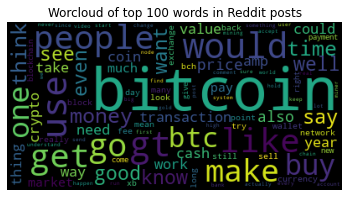

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Worcloud of top 50 words in Reddit posts')

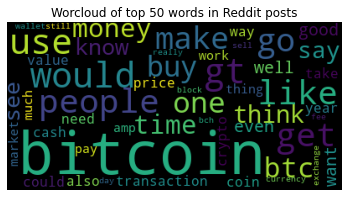

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Worcloud of top 20 words in Reddit posts')

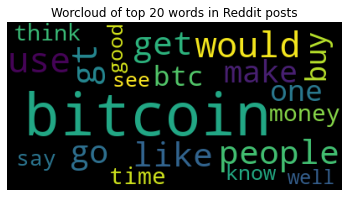

In [54]:
for i in [100,50,20]:
    wordcloud_posts = WordCloud(max_words=i, background_color = 'black', colormap = None)
    wordcloud_posts.generate_from_frequencies(wordcloud_freq_posts)
    plt.imshow(wordcloud_posts)
    plt.axis('off')
    plt.title(f"Worcloud of top {i} words in Reddit posts")
    plt.show()

# Word Frequency

In [55]:
word_freq_posts = pd.DataFrame(wordcloud_freq_posts).reset_index()
word_freq_posts.columns = ['Word', 'Count']
word_freq_posts.head()

Word  Count
0       aa    130
1       ab    145
2  abandon    930
3      abc   2563
4    abide    166

In [56]:
# Let's check the most frequent words
word_freq_posts = word_freq_posts.sort_values(by='Count', ascending=False)

In [57]:
# Let's create a barchart of frequencies
top20_posts = word_freq_posts[0:19].copy()
top20_posts

Word   Count
611   bitcoin  630525
6606      use  128596
2805       gt  126231
6921    would  125310
3608     like  114579
4529   people  111715
2696      get  109003
2729       go  103264
3740     make   93931
4306      one   85357
843       buy   80515
788       btc   77035
4018    money   76711
6267     time   76331
6223    think   75992
5401      say   68959
3481     know   63843
5475      see   62524
2741     good   61643

<BarContainer object of 19 artists>

Text(0.5, 1.0, 'Top 20 words in posts')

Text(0.5, 0, 'Frequency')

Text(0, 0.5, 'Word')

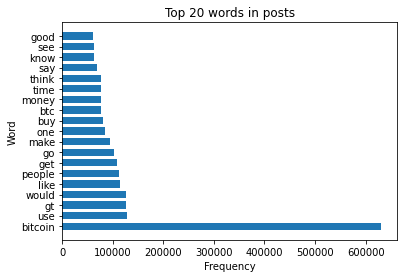

In [58]:
plt.barh(y=top20_posts['Word'],width=top20_posts['Count'], height = 0.7)
plt.title("Top 20 words in posts")
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [59]:
final_list = []
for word in top20_posts["Word"]:
    final_list.append(word)

# Text representation

## Using fast text

In [60]:
# Create corpus vectors from the top 5000 words in the comments and posts
corpus_posts = reddit_corpus['posts_body_lim']

In [61]:
final_size = 60
window_size = 10
min_word = 3
corpus_posts

3816338    [look, lightning, payment, work, similar, iou,...
3816339    [gt, blockstream, core, devs, well, yeah, lie,...
3816340    [child, tell, thank, god, buy, first, hear, bi...
3816341    [expect, balanced, response, anywhere, else, e...
3816342                     [lol, ass, buy, single, bitcoin]
                                 ...                        
4309238    [gt, fee, exist, pay, convenience, mandatory, ...
4309239                               [put, saving, bitcoin]
4309240    [litecoin, another, shitcoin, use, testing, te...
4309242    [luke, see, bitcoin, effort, people, bitcoin, ...
4309243                                        [th, bitcoin]
Name: posts_body_lim, Length: 384068, dtype: object

In [62]:
from gensim.models.fasttext import FastText

In [63]:
# Create the fast text models for both vectors

model_posts = FastText(vector_size=final_size,
                       window=window_size,
                       min_count=min_word,
                       seed=1,
                       workers=1)
model_posts.build_vocab(corpus_iterable = corpus_posts)
model_posts.train(corpus_iterable=corpus_posts, total_examples=len(corpus_posts), epochs=50)

(688685984, 759807500)

In [64]:
# 60-dimensional vector for the word "bitcoin"
model_posts.wv['bitcoin']

array([ 1.0748047 , -0.12063371, -1.4643712 ,  1.0360857 , -0.3141465 ,
       -0.19902234, -1.5168715 , -0.16717774,  0.67783827, -2.0661268 ,
       -2.0330417 , -3.4011552 ,  0.24071123,  1.2948812 ,  0.80598533,
       -0.34392402,  0.41112924, -1.7039783 ,  1.605835  ,  0.08431526,
        1.3102217 , -0.7007734 , -1.8870393 ,  2.185653  ,  1.7488533 ,
        0.26649186,  2.0040374 , -0.9011434 , -2.1621203 ,  0.21192715,
       -0.1843843 ,  1.3169906 , -0.15059413, -0.32337135, -1.6218402 ,
        1.2918804 ,  0.02341125,  0.06195299,  1.7408177 , -4.093877  ,
       -0.9597047 , -0.6875522 ,  1.3650624 , -1.1101562 , -0.97023606,
        2.4462852 ,  0.56255525, -1.8638929 , -1.2982742 ,  0.86489344,
       -2.0629165 , -0.37842387,  0.58196807,  1.7374231 ,  1.7182409 ,
       -1.4540223 , -1.2670442 ,  1.4448005 , -1.4366157 ,  2.609024  ],
      dtype=float32)

In [65]:
model_posts.wv.most_similar('bitcoin', topn=5)

[('btc', 0.6917376518249512),
 ('bitcoinsv', 0.6312445998191833),
 ('cash', 0.5973615050315857),
 ('shitcoin', 0.5881274938583374),
 ('bitcoincash', 0.5867718458175659)]

In [66]:
model_posts.wv.similarity(w1='bitcoin', w2='btc')

0.6917376

In [67]:
# Save the model
pickle.dump(model_posts, open('data/fast_text_model_posts.pkl', 'wb'))

In [68]:
# Visualize the model
X_posts = model_posts.wv[final_list]
X_posts #an array with all 60-D vectors for all the words in final_list

array([[  1.0748047 ,  -0.12063371,  -1.4643712 , ...,   1.4448005 ,
         -1.4366157 ,   2.609024  ],
       [  1.7031126 ,  -5.684257  ,   5.6685247 , ...,  -2.4359226 ,
         -3.9078624 ,  -3.761143  ],
       [  5.7180853 ,   3.6651835 ,  11.287215  , ...,  -3.8781774 ,
          1.773227  ,  -3.171998  ],
       ...,
       [  0.59574014,  -3.5392427 ,   3.287509  , ...,   0.21155816,
          4.1743016 , -10.217899  ],
       [ -2.194883  ,  -2.9799035 ,  -2.347014  , ...,   1.5423671 ,
          6.9008307 ,  -7.3425508 ],
       [ 10.741414  ,  -5.7835617 ,   0.05692907, ...,   3.5183141 ,
          2.9716723 ,  -3.0217445 ]], dtype=float32)

In [69]:
from sklearn.decomposition import PCA

In [70]:
# To plot sth nice let's reduce the 60 dimensions to 2
pca_posts = PCA(n_components=2).fit_transform(X_posts)
pca_posts

array([[  4.283955  ,   2.6401248 ],
       [  4.0043364 ,  16.675148  ],
       [ 59.874344  ,   1.1189656 ],
       [ -2.4015176 ,  -3.4924319 ],
       [ -2.4418464 ,  -4.003311  ],
       [ -2.097486  ,  -2.5829325 ],
       [-17.246515  ,  -5.052652  ],
       [-23.674438  ,  -1.8634593 ],
       [ -2.2185085 ,  -6.0676627 ],
       [  3.806278  ,  -7.2407846 ],
       [-21.094307  ,  31.006615  ],
       [ 12.069416  ,  26.392456  ],
       [ -7.368972  ,  -0.17815314],
       [ -7.431482  ,  -6.9469223 ],
       [ -0.0808569 ,  -7.4931636 ],
       [  8.016318  ,  -7.0872617 ],
       [ -0.283729  ,  -8.778921  ],
       [ -3.4752557 ,  -9.95795   ],
       [ -2.239752  ,  -7.087701  ]], dtype=float32)

In [71]:
# Import
import plotly.express as px
#import matplotlib.pyplot as plt


In [72]:
fig = px.scatter(x = pca_posts[:,0], y = pca_posts[:,1], text = final_list)
fig.update_traces(textposition='top center', textfont_size=14)
fig.show()


# Import Libraries

In [73]:
!pip install textblob

In [5]:
from sklearn import preprocessing

#Lexicons
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

#Display every call in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vraci\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
reddit_corpus = pd.read_csv(os.path.join("data", "reddit_corpus_cleaned.csv"))

In [3]:
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
0  2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
1  2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                body language  word_len_body  \
0  If you look at how Lightning payments work, th...       en            246   
1   gt Blockstream = Core Devs.\n\nWell yeah... t...       en             65   

                                          posts_body  \
0  look lightning payment work similar iou bearer...   
1  gt blockstream core devs well yeah lie bcasher...   

                                      posts_body_lim  
0  ['look', 'lightning', 'payment', 'work', 'simi...  
1  ['gt', 'blockstream', 'core', 'devs', 'well', ...

# 2. Sentiment Analysis using Vader Lexicon

In [ ]:
reddit_corpus['posts_body_vader_score'] = reddit_corpus['body'].apply(
    lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])
reddit_corpus[['body', 'posts_body_vader_score']] .head(2)
reddit_corpus['posts_body_vader_score'].describe()

In [78]:
reddit_corpus.describe()

score  controversiality  word_len_body  posts_body_vader_score
count  384068.000000     384068.000000  384068.000000           384068.000000
mean        5.026355          0.042539      95.782502                0.213029
std        87.655484          0.201816     145.378722                0.563737
min      -141.000000          0.000000       1.000000               -0.999800
25%         1.000000          0.000000      25.000000               -0.153100
50%         2.000000          0.000000      53.000000                0.286900
75%         4.000000          0.000000     108.000000                0.714000
max     29179.000000          1.000000    3750.000000                0.999900

# Add a column to categorize the sentiments into positive, neutral and negative

In [79]:
# Add a new column for categorical data
positive = []
for score in reddit_corpus['posts_body_vader_score']:
    if score >= 0.05:
        positive.append("positive")
    elif score <= -0.05:
        positive.append("negative")
    else:
        positive.append("neutral")

reddit_corpus['body_positive']= positive
reddit_corpus.head(2)

datetime        date subreddit  score  controversiality  \
0  2019-09-28 00:38:16  2019-09-28       btc   23.0               0.0   
1  2019-09-04 00:45:54  2019-09-04       btc  -11.0               0.0   

                                                body language  word_len_body  \
0  If you look at how Lightning payments work, th...       en            246   
1   gt Blockstream = Core Devs.\n\nWell yeah... t...       en             65   

                                          posts_body  \
0  look lightning payment work similar iou bearer...   
1  gt blockstream core devs well yeah lie bcasher...   

                                      posts_body_lim  posts_body_vader_score  \
0  ['look', 'lightning', 'payment', 'work', 'simi...                   0.969   
1  ['gt', 'blockstream', 'core', 'devs', 'well', ...                  -0.461   

  body_positive  
0      positive  
1      negative

Text(0.5, 1.0, 'Frequency of sentiments for Reddit posts')

Text(0.5, 0, 'Sentiment')

Text(0, 0.5, 'Frequency')

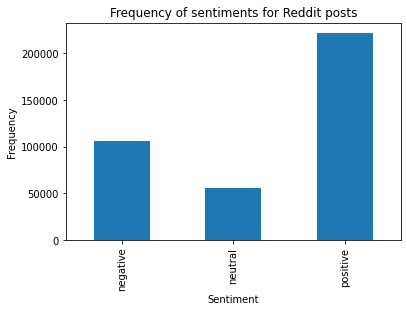

In [80]:
import matplotlib.pyplot as plt

fig = reddit_corpus['body_positive'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of sentiments for Reddit posts')
fig.set_xlabel('Sentiment')
fig.set_ylabel('Frequency')
plt.show()

In [81]:
# Save the corpus
reddit_corpus.to_csv(os.path.join("data", "reddit_body_cleaned.csv"), index=False)

# Get the price historical

In [82]:
df_bitcoin = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [83]:
df_bitcoin.head(5)

Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [84]:
import datetime

In [85]:
def tt(x):
    return datetime.datetime.fromtimestamp(x)

In [86]:
df_bitcoin['Timestamp'] = df_bitcoin['Timestamp'].progress_apply(tt)

100%|██████████| 4857377/4857377 [00:04<00:00, 1090693.79it/s]


In [87]:
df_bitcoin.head()

Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 09:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 09:53:00   NaN   NaN   NaN    NaN           NaN   
2 2011-12-31 09:54:00   NaN   NaN   NaN    NaN           NaN   
3 2011-12-31 09:55:00   NaN   NaN   NaN    NaN           NaN   
4 2011-12-31 09:56:00   NaN   NaN   NaN    NaN           NaN   

   Volume_(Currency)  Weighted_Price  
0                2.0            4.39  
1                NaN             NaN  
2                NaN             NaN  
3                NaN             NaN  
4                NaN             NaN

In [88]:
df_bitcoin = df_bitcoin.dropna()

In [89]:
df_bitcoin.head(10)

Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0    2011-12-31 09:52:00  4.39  4.39  4.39   4.39      0.455581   
478  2011-12-31 17:50:00  4.39  4.39  4.39   4.39     48.000000   
547  2011-12-31 18:59:00  4.50  4.57  4.50   4.57     37.862297   
548  2011-12-31 19:00:00  4.58  4.58  4.58   4.58      9.000000   
1224 2012-01-01 06:16:00  4.58  4.58  4.58   4.58      1.502000   
1896 2012-01-01 17:28:00  4.84  4.84  4.84   4.84     10.000000   
2333 2012-01-02 00:45:00  5.00  5.00  5.00   5.00     10.100000   
3612 2012-01-02 22:04:00  5.00  5.00  5.00   5.00     19.048000   
4553 2012-01-03 13:45:00  5.32  5.32  5.32   5.32      2.419173   
4710 2012-01-03 16:22:00  5.14  5.14  5.14   5.14      0.680000   

      Volume_(Currency)  Weighted_Price  
0              2.000000        4.390000  
478          210.720000        4.390000  
547          171.380338        4.526411  
548           41.220000        4.580000  
1224           6.879160        4.580000  
1896          48.400000        4.840000  
2333          50.500000        5.000000  
3612          95.240000        5.000000  
4553          12.870000        5.320000  
4710           3.495200        5.140000

In [90]:
df_bitcoin.isna().any()

Timestamp            False
Open                 False
High                 False
Low                  False
Close                False
Volume_(BTC)         False
Volume_(Currency)    False
Weighted_Price       False
dtype: bool

In [91]:
min(df_bitcoin["Timestamp"])

Timestamp('2011-12-31 09:52:00')

In [92]:
max(df_bitcoin["Timestamp"])

Timestamp('2021-03-31 03:00:00')

In [93]:
df_bitcoin['date'] = df_bitcoin['Timestamp'].progress_apply(dt)

100%|██████████| 3613769/3613769 [00:07<00:00, 464384.03it/s] 


In [94]:
#df_bitcoin = df_bitcoin[df_bitcoin['date']>= datetime.date(2019, 10, 1)]
df_bitcoin = df_bitcoin[df_bitcoin['date']>= datetime.date(2019, 1, 1)]


In [95]:
#df_bitcoin = df_bitcoin[df_bitcoin['date']<= datetime.date(2019, 12, 31)]
df_bitcoin = df_bitcoin[df_bitcoin['date']<= datetime.date(2019, 9, 30)]


In [96]:
df_bitcoin.head(5)

Timestamp     Open     High      Low    Close  Volume_(BTC)  \
3676456 2019-01-01 00:00:00  3676.06  3676.06  3675.01  3675.01      0.190663   
3676457 2019-01-01 00:01:00  3674.58  3674.68  3663.80  3663.80     15.448820   
3676458 2019-01-01 00:02:00  3664.41  3664.41  3664.41  3664.41      0.015697   
3676459 2019-01-01 00:03:00  3666.13  3669.13  3662.85  3669.13     27.152987   
3676460 2019-01-01 00:04:00  3667.15  3667.71  3656.60  3663.14     39.131274   

         Volume_(Currency)  Weighted_Price        date  
3676456         700.842634     3675.822625  2019-01-01  
3676457       56671.806953     3668.358226  2019-01-01  
3676458          57.520244     3664.410000  2019-01-01  
3676459       99532.493706     3665.618606  2019-01-01  
3676460      143193.243150     3659.304430  2019-01-01

In [97]:
len(df_bitcoin)

377318

<AxesSubplot:xlabel='Timestamp'>

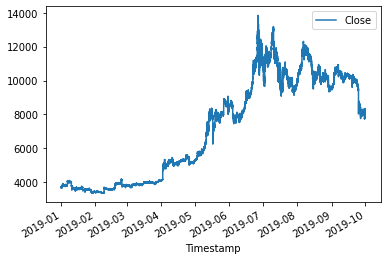

In [98]:
df_bitcoin.plot(x="Timestamp",y="Close", kind="line")
plt.show()

Media pe date

In [99]:
df_bitcoin_average= df_bitcoin.groupby("date").mean()

In [100]:
df_bitcoin_average.head()

Open         High          Low        Close  Volume_(BTC)  \
date                                                                           
2019-01-01  3694.235684  3695.484407  3693.154456  3694.305362      3.860667   
2019-01-02  3812.088794  3813.928618  3810.812580  3812.489260      4.419870   
2019-01-03  3838.199899  3839.500272  3837.090210  3838.446314      3.936751   
2019-01-04  3781.277041  3782.671240  3780.132450  3781.503579      5.501520   
2019-01-05  3836.128180  3837.466656  3835.106738  3836.441713      2.983162   

            Volume_(Currency)  Weighted_Price  
date                                           
2019-01-01       14271.618718     3694.211685  
2019-01-02       16870.480923     3812.357528  
2019-01-03       15072.495076     3838.178627  
2019-01-04       20824.941769     3781.314953  
2019-01-05       11447.657553     3836.232920

In [101]:
df_bitcoin_average.keys()

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')

In [102]:
df_bitcoin_average = df_bitcoin_average.reset_index()

In [103]:
df_bitcoin_average

date         Open         High          Low        Close  \
0    2019-01-01  3694.235684  3695.484407  3693.154456  3694.305362   
1    2019-01-02  3812.088794  3813.928618  3810.812580  3812.489260   
2    2019-01-03  3838.199899  3839.500272  3837.090210  3838.446314   
3    2019-01-04  3781.277041  3782.671240  3780.132450  3781.503579   
4    2019-01-05  3836.128180  3837.466656  3835.106738  3836.441713   
..          ...          ...          ...          ...          ...   
268  2019-09-26  8303.217169  8310.626987  8294.426764  8301.233863   
269  2019-09-27  8025.109638  8030.777591  8018.176532  8022.921045   
270  2019-09-28  8162.472924  8167.005647  8156.720503  8159.964533   
271  2019-09-29  8086.834228  8091.337487  8080.503592  8083.660229   
272  2019-09-30  8048.903792  8054.641882  8042.059733  8046.556074   

     Volume_(BTC)  Volume_(Currency)  Weighted_Price  
0        3.860667       14271.618718     3694.211685  
1        4.419870       16870.480923     3812.357528  
2        3.936751       15072.495076     3838.178627  
3        5.501520       20824.941769     3781.314953  
4        2.983162       11447.657553     3836.232920  
..            ...                ...             ...  
268     12.469729      101819.421953     8303.234702  
269      6.556475       52534.050567     8025.152515  
270      4.358156       35561.947454     8162.158564  
271      4.407869       35672.228470     8086.653308  
272      7.098123       57207.133866     8048.824629  

[273 rows x 8 columns]

<AxesSubplot:xlabel='date'>

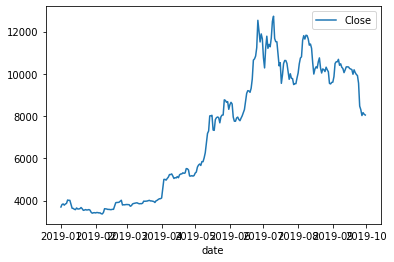

In [104]:
df_bitcoin_average.plot(x="date",y="Close", kind="line")
plt.show()

In [105]:
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'])

In [106]:
df_bitcoin

Timestamp     Open     High      Low    Close  Volume_(BTC)  \
3676456 2019-01-01 00:00:00  3676.06  3676.06  3675.01  3675.01      0.190663   
3676457 2019-01-01 00:01:00  3674.58  3674.68  3663.80  3663.80     15.448820   
3676458 2019-01-01 00:02:00  3664.41  3664.41  3664.41  3664.41      0.015697   
3676459 2019-01-01 00:03:00  3666.13  3669.13  3662.85  3669.13     27.152987   
3676460 2019-01-01 00:04:00  3667.15  3667.71  3656.60  3663.14     39.131274   
...                     ...      ...      ...      ...      ...           ...   
4069511 2019-09-30 23:55:00  8224.89  8228.33  8222.42  8228.33      0.810178   
4069512 2019-09-30 23:56:00  8224.41  8230.00  8224.41  8225.71      0.457575   
4069513 2019-09-30 23:57:00  8226.55  8230.00  8221.44  8230.00      0.240900   
4069514 2019-09-30 23:58:00  8230.00  8243.30  8230.00  8235.27      0.083844   
4069515 2019-09-30 23:59:00  8238.80  8243.27  8229.77  8233.83      1.376990   

         Volume_(Currency)  Weighted_Price       date  
3676456         700.842634     3675.822625 2019-01-01  
3676457       56671.806953     3668.358226 2019-01-01  
3676458          57.520244     3664.410000 2019-01-01  
3676459       99532.493706     3665.618606 2019-01-01  
3676460      143193.243150     3659.304430 2019-01-01  
...                    ...             ...        ...  
4069511        6664.648774     8226.158194 2019-09-30  
4069512        3764.078642     8226.141256 2019-09-30  
4069513        1982.045367     8227.671339 2019-09-30  
4069514         690.435266     8234.718342 2019-09-30  
4069515       11343.222277     8237.696703 2019-09-30  

[377318 rows x 9 columns]

In [107]:
df_bitcoin.dtypes

Timestamp            datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
date                 datetime64[ns]
dtype: object

In [108]:
reddit_corpus['date'] = pd.to_datetime(reddit_corpus['date'])

In [109]:
reddit_corpus

datetime       date            subreddit  score  \
0       2019-09-28 00:38:16 2019-09-28                  btc   23.0   
1       2019-09-04 00:45:54 2019-09-04                  btc  -11.0   
2       2019-09-20 01:22:52 2019-09-20       BitcoinMarkets   15.0   
3       2019-09-07 01:40:28 2019-09-07                  btc  -12.0   
4       2019-09-03 02:20:25 2019-09-03  canconfirmiamindian   18.0   
...                     ...        ...                  ...    ...   
384063  2019-03-08 20:25:08 2019-03-08             Buttcoin   -1.0   
384064  2019-03-16 16:23:45 2019-03-16          teslamotors   -1.0   
384065  2019-03-20 22:14:09 2019-03-20              Bitcoin   -1.0   
384066  2019-03-24 19:05:11 2019-03-24                  btc   -1.0   
384067  2019-03-30 02:25:53 2019-03-30              Bitcoin   -1.0   

        controversiality                                               body  \
0                    0.0  If you look at how Lightning payments work, th...   
1                    0.0   gt Blockstream = Core Devs.\n\nWell yeah... t...   
2                    0.0  My children told me once, thank god you didn t...   
3                    0.0  don t expect balanced response here, or anywhe...   
4                    0.0  Lol that ass licker doesn t have the aukat to ...   
...                  ...                                                ...   
384063               0.0   gt The fees exist because you are paying for ...   
384064               0.0                 Put % of those savings in Bitcoin.   
384065               1.0  Litecoin is another shitcoin used for testing ...   
384066               0.0  luke sees bitcoin as a collaborative effort be...   
384067               1.0                          1,000,000th of a bitcoin    

       language  word_len_body  \
0            en            246   
1            en             65   
2            en             38   
3            en             25   
4            en             15   
...         ...            ...   
384063       en            320   
384064       en              8   
384065       en             22   
384066       en            124   
384067       en              4   

                                               posts_body  \
0       look lightning payment work similar iou bearer...   
1       gt blockstream core devs well yeah lie bcasher...   
2       child tell thank god buy first hear bitcoin wo...   
3       expect balanced response anywhere else especia...   
4                 lol ass licker aukat buy single bitcoin   
...                                                   ...   
384063  gt fee exist pay convenience mandatory take ti...   
384064                                 put saving bitcoin   
384065  litecoin another shitcoin use testing tech imp...   
384066  luke see bitcoin collaborative effort people b...   
384067                                         th bitcoin   

                                           posts_body_lim  \
0       ['look', 'lightning', 'payment', 'work', 'simi...   
1       ['gt', 'blockstream', 'core', 'devs', 'well', ...   
2       ['child', 'tell', 'thank', 'god', 'buy', 'firs...   
3       ['expect', 'balanced', 'response', 'anywhere',...   
4              ['lol', 'ass', 'buy', 'single', 'bitcoin']   
...                                                   ...   
384063  ['gt', 'fee', 'exist', 'pay', 'convenience', '...   
384064                       ['put', 'saving', 'bitcoin']   
384065  ['litecoin', 'another', 'shitcoin', 'use', 'te...   
384066  ['luke', 'see', 'bitcoin', 'effort', 'people',...   
384067                                  ['th', 'bitcoin']   

        posts_body_vader_score body_positive  
0                       0.9690      positive  
1                      -0.4610      negative  
2                       0.8316      positive  
3                      -0.3612      negative  
4                      -0.1779      negative  
...                        ...           ...  
384063                  0

In [110]:
reddit_corpus.dtypes

datetime                          object
date                      datetime64[ns]
subreddit                         object
score                            float64
controversiality                 float64
body                              object
language                          object
word_len_body                      int64
posts_body                        object
posts_body_lim                    object
posts_body_vader_score           float64
body_positive                     object
dtype: object

# Merge the two dataframe into a single one

In [111]:
pickle_out=open('data/reddit_corpus.pkl','wb')
pickle.dump(reddit_corpus, pickle_out)
pickle_out.close()

In [112]:
pickle_out=open('data/df_bitcoin.pkl','wb')
pickle.dump(df_bitcoin, pickle_out)
pickle_out.close()

In [113]:
pickle_in=open('data/reddit_corpus.pkl','rb')
reddit_corpus=pickle.load(pickle_in)
pickle_in.close()

In [114]:
pickle_in=open('data/df_bitcoin.pkl','rb')
df_bitcoin=pickle.load(pickle_in)
pickle_in.close()

In [115]:
df_bitcoin_average['date'] = pd.to_datetime(df_bitcoin_average['date'])

In [116]:
reddit = pd.merge(reddit_corpus, df_bitcoin_average, on="date")
reddit

datetime       date            subreddit  score  \
0       2019-09-28 00:38:16 2019-09-28                  btc   23.0   
1       2019-09-28 10:36:34 2019-09-28  UnresolvedMysteries   17.0   
2       2019-09-28 18:40:32 2019-09-28                  btc   -7.0   
3       2019-09-28 18:57:09 2019-09-28       BitcoinMarkets  -21.0   
4       2019-09-28 02:05:55 2019-09-28       BitcoinMarkets  -10.0   
...                     ...        ...                  ...    ...   
384063  2019-03-04 18:07:39 2019-03-04       BitcoinMarkets   -1.0   
384064  2019-03-04 01:15:34 2019-03-04                  btc   -1.0   
384065  2019-03-04 06:54:15 2019-03-04       CryptoCurrency   -1.0   
384066  2019-03-04 21:45:15 2019-03-04              Bitcoin   -1.0   
384067  2019-03-04 18:00:55 2019-03-04       BitcoinMarkets   -1.0   

        controversiality                                               body  \
0                    0.0  If you look at how Lightning payments work, th...   
1                    0.0  theoretically, wouldn t selling that much Bitc...   
2                    0.0   At the moment, you could build a 2 gb block o...   
3                    0.0  I don t think anyone understands whats going o...   
4                    0.0  IMO there is one problem with all of this: peo...   
...                  ...                                                ...   
384063               0.0  agreed. jeanduluoz, good riddance. I hope he f...   
384064               1.0  Yeah. This is the first time I hear that Googl...   
384065               0.0   gt Literlly a few btc enough for a total wide...   
384066               1.0  It s been trending down since January 018. It’...   
384067               0.0  If you are as interested in sound money as you...   

       language  word_len_body  \
0            en            246   
1            en             20   
2            en            286   
3            en            149   
4            en            142   
...         ...            ...   
384063       en             31   
384064       en             72   
384065       en            127   
384066       en             69   
384067       en             84   

                                               posts_body  \
0       look lightning payment work similar iou bearer...   
1       theoretically sell much bitcoin actually defla...   
2       moment could build gb block bsv also op return...   
3       think anyone understand go right huge forum bi...   
4       go one problem people year ago dump recovery l...   
...                                                   ...   
384063  agree jeanduluoz good riddance hope find well ...   
384064  yeah first time hear google send warning gover...   
384065  gt literlly btc enough total wide global curre...   
384066  trend since january go continue drop alt good ...   
384067  interested sound money post would see bitcoin ...   

                                           posts_body_lim  \
0       ['look', 'lightning', 'payment', 'work', 'simi...   
1       ['theoretically', 'sell', 'much', 'bitcoin', '...   
2       ['moment', 'could', 'build', 'gb', 'block', 'b...   
3       ['think', 'anyone', 'understand', 'go', 'right...   
4       ['go', 'one', 'problem', 'people', 'year', 'ag...   
...                                                   ...   
384063  ['agree', 'good', 'hope', 'find', 'well', 'hob...   
384064  ['yeah', 'first', 'time', 'hear', 'google', 's...   
384065  ['gt', 'btc', 'enough', 'total', 'wide', 'glob...   
384066  ['trend', 'since', 'january', 'go', 'continue'...   
384067  ['interested', 'sound', 'money', 'post', 'woul...   

        posts_body_vader_score body_positive         Open         High  \
0                       0.9690      positive  8162.472924  8167.005647   
1                       0.5204      positive  8162.472924  8167.005647   
2                      -0.8765      negative  8162.472924  8167.005647   
3                      -0.2928      negative  8162.472924 

In [117]:
pickle_out=open('data/reddit_merged.pkl','wb')
pickle.dump(reddit, pickle_out)
pickle_out.close()

In [118]:
reddit_corpus.to_csv(os.path.join("data", "reddit_merged.csv"), index=False)

Corelatie

In [119]:
pickle_in=open('data/reddit_merged.pkl','rb')
reddit_corpus=pickle.load(pickle_in)
pickle_in.close()

In [120]:
reddit_corpus.corr()

score  controversiality  word_len_body  \
score                   1.000000         -0.011329       0.002554   
controversiality       -0.011329          1.000000      -0.015530   
word_len_body           0.002554         -0.015530       1.000000   
posts_body_vader_score -0.004015         -0.031031       0.145382   
Open                   -0.004336         -0.005898       0.004433   
High                   -0.004337         -0.005902       0.004415   
Low                    -0.004335         -0.005894       0.004450   
Close                  -0.004337         -0.005897       0.004429   
Volume_(BTC)           -0.004355         -0.003277      -0.019359   
Volume_(Currency)      -0.004301         -0.005088      -0.014821   
Weighted_Price         -0.004336         -0.005898       0.004434   

                        posts_body_vader_score      Open      High       Low  \
score                                -0.004015 -0.004336 -0.004337 -0.004335   
controversiality                     -0.031031 -0.005898 -0.005902 -0.005894   
word_len_body                         0.145382  0.004433  0.004415  0.004450   
posts_body_vader_score                1.000000  0.005323  0.005318  0.005329   
Open                                  0.005323  1.000000  1.000000  1.000000   
High                                  0.005318  1.000000  1.000000  0.999998   
Low                                   0.005329  1.000000  0.999998  1.000000   
Close                                 0.005324  1.000000  1.000000  1.000000   
Volume_(BTC)                         -0.003965  0.295982  0.296688  0.295253   
Volume_(Currency)                    -0.001289  0.619930  0.620558  0.619280   
Weighted_Price                        0.005323  1.000000  1.000000  1.000000   

                           Close  Volume_(BTC)  Volume_(Currency)  \
score                  -0.004337     -0.004355          -0.004301   
controversiality       -0.005897     -0.003277          -0.005088   
word_len_body           0.004429     -0.019359          -0.014821   
posts_body_vader_score  0.005324     -0.003965          -0.001289   
Open                    1.000000      0.295982           0.619930   
High                    1.000000      0.296688           0.620558   
Low                     1.000000      0.295253           0.619280   
Close                   1.000000      0.296024           0.619966   
Volume_(BTC)            0.296024      1.000000           0.891777   
Volume_(Currency)       0.619966      0.891777           1.000000   
Weighted_Price          1.000000      0.295937           0.619892   

                        Weighted_Price  
score                        -0.004336  
controversiality             -0.005898  
word_len_body                 0.004434  
posts_body_vader_score        0.005323  
Open                          1.000000  
High                          1.000000  
Low                           1.000000  
Close                         1.000000  
Volume_(BTC)                  0.295937  
Volume_(Currency)             0.619892  
Weighted_Price                1.000000

In [121]:
# Save the corpus in a csv
reddit_corpus.to_csv(os.path.join("data", "reddit_score_price.csv"))

# Normalize the data

In [122]:
reddit_corpus.head(5)

datetime       date            subreddit  score  \
0  2019-09-28 00:38:16 2019-09-28                  btc   23.0   
1  2019-09-28 10:36:34 2019-09-28  UnresolvedMysteries   17.0   
2  2019-09-28 18:40:32 2019-09-28                  btc   -7.0   
3  2019-09-28 18:57:09 2019-09-28       BitcoinMarkets  -21.0   
4  2019-09-28 02:05:55 2019-09-28       BitcoinMarkets  -10.0   

   controversiality                                               body  \
0               0.0  If you look at how Lightning payments work, th...   
1               0.0  theoretically, wouldn t selling that much Bitc...   
2               0.0   At the moment, you could build a 2 gb block o...   
3               0.0  I don t think anyone understands whats going o...   
4               0.0  IMO there is one problem with all of this: peo...   

  language  word_len_body                                         posts_body  \
0       en            246  look lightning payment work similar iou bearer...   
1       en             20  theoretically sell much bitcoin actually defla...   
2       en            286  moment could build gb block bsv also op return...   
3       en            149  think anyone understand go right huge forum bi...   
4       en            142  go one problem people year ago dump recovery l...   

                                      posts_body_lim  posts_body_vader_score  \
0  ['look', 'lightning', 'payment', 'work', 'simi...                  0.9690   
1  ['theoretically', 'sell', 'much', 'bitcoin', '...                  0.5204   
2  ['moment', 'could', 'build', 'gb', 'block', 'b...                 -0.8765   
3  ['think', 'anyone', 'understand', 'go', 'right...                 -0.2928   
4  ['go', 'one', 'problem', 'people', 'year', 'ag...                 -0.9006   

  body_positive         Open         High          Low        Close  \
0      positive  8162.472924  8167.005647  8156.720503  8159.964533   
1      positive  8162.472924  8167.005647  8156.720503  8159.964533   
2      negative  8162.472924  8167.005647  8156.720503  8159.964533   
3      negative  8162.472924  8167.005647  8156.720503  8159.964533   
4      negative  8162.472924  8167.005647  8156.720503  8159.964533   

   Volume_(BTC)  Volume_(Currency)  Weighted_Price  
0      4.358156       35561.947454     8162.158564  
1      4.358156       35561.947454     8162.158564  
2      4.358156       35561.947454     8162.158564  
3      4.358156       35561.947454     8162.158564  
4      4.358156       35561.947454     8162.158564

In [123]:
reddit_corpus = reddit_corpus.drop(columns=['datetime', 'subreddit', 'controversiality', 'body', 'language', 'posts_body', 'posts_body_lim', 'body_positive'])

In [124]:
reddit_corpus.set_index('date', inplace=True)

In [125]:
x = reddit_corpus.values

In [126]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [127]:
x_scaled

array([[0.00559345, 0.06535076, 0.98454768, ..., 0.12874255, 0.09406581,
        0.51257555],
       [0.00538881, 0.00506802, 0.76021403, ..., 0.12874255, 0.09406581,
        0.51257555],
       [0.00457026, 0.07602027, 0.06165925, ..., 0.12874255, 0.09406581,
        0.51257555],
       ...,
       [0.0047749 , 0.03360896, 0.04055608, ..., 0.1774146 , 0.0465366 ,
        0.03880686],
       [0.0047749 , 0.01813817, 0.77871681, ..., 0.1774146 , 0.0465366 ,
        0.03880686],
       [0.0047749 , 0.02213924, 0.72020803, ..., 0.1774146 , 0.0465366 ,
        0.03880686]])

In [128]:
# Normalize
reddit_corpus_norm = pd.DataFrame(x_scaled, index=reddit_corpus.index,
                                 columns=[ 'score_norm',
                                           'world_len_body_norm',
                                           'posts_body_vader_score_norm',
                                           'Open_norm',
                                           'High_norm',
                                           'Low_norm',
                                           'Close_norm',
                                           'Volume_(BTC)_norm',
                                           'Volume_(Currency)_norm',
                                           'Weighted_Price_norm'
                                          ])
reddit_corpus_norm

score_norm  world_len_body_norm  posts_body_vader_score_norm  \
date                                                                       
2019-09-28    0.005593             0.065351                     0.984548   
2019-09-28    0.005389             0.005068                     0.760214   
2019-09-28    0.004570             0.076020                     0.061659   
2019-09-28    0.004093             0.039477                     0.353553   
2019-09-28    0.004468             0.037610                     0.049607   
...                ...                  ...                          ...   
2019-03-04    0.004775             0.008002                     0.863480   
2019-03-04    0.004775             0.018938                     0.256388   
2019-03-04    0.004775             0.033609                     0.040556   
2019-03-04    0.004775             0.018138                     0.778717   
2019-03-04    0.004775             0.022139                     0.720208   

            Open_norm  High_norm  Low_norm  Close_norm  Volume_(BTC)_norm  \
date                                                                        
2019-09-28   0.512516   0.512340  0.512681    0.512294           0.128743   
2019-09-28   0.512516   0.512340  0.512681    0.512294           0.128743   
2019-09-28   0.512516   0.512340  0.512681    0.512294           0.128743   
2019-09-28   0.512516   0.512340  0.512681    0.512294           0.128743   
2019-09-28   0.512516   0.512340  0.512681    0.512294           0.128743   
...               ...        ...       ...         ...                ...   
2019-03-04   0.038815   0.038814  0.038806    0.038812           0.177415   
2019-03-04   0.038815   0.038814  0.038806    0.038812           0.177415   
2019-03-04   0.038815   0.038814  0.038806    0.038812           0.177415   
2019-03-04   0.038815   0.038814  0.038806    0.038812           0.177415   
2019-03-04   0.038815   0.038814  0.038806    0.038812           0.177415   

            Volume_(Currency)_norm  Weighted_Price_norm  
date                                                     
2019-09-28                0.094066             0.512576  
2019-09-28                0.094066             0.512576  
2019-09-28                0.094066             0.512576  
2019-09-28                0.094066             0.512576  
2019-09-28                0.094066             0.512576  
...                            ...                  ...  
2019-03-04                0.046537             0.038807  
2019-03-04                0.046537             0.038807  
2019-03-04                0.046537             0.038807  
2019-03-04                0.046537             0.038807  
2019-03-04                0.046537             0.038807  

[384068 rows x 10 columns]

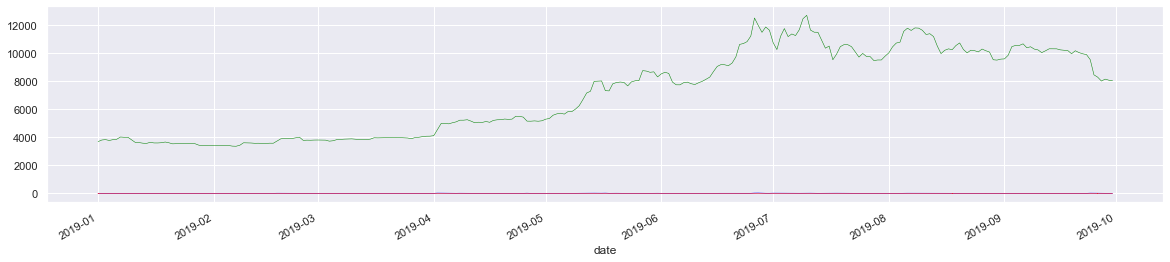

In [129]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
reddit_corpus['Weighted_Price'].plot(linewidth=0.5, color='green');
reddit_corpus['Volume_(BTC)'].plot(linewidth=0.5, color='blue');
reddit_corpus['posts_body_vader_score'].plot(linewidth=0.5, color='red');

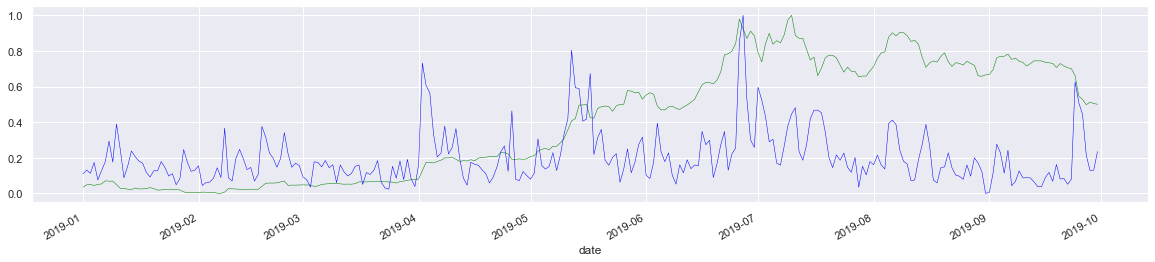

In [130]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
reddit_corpus_norm['Weighted_Price_norm'].plot(linewidth=0.5, color="green");
# reddit_corpus_norm['deaths_norm'].plot(linewidth=0.5,  color="blue");
reddit_corpus_norm['Volume_(BTC)_norm'].plot(linewidth=0.5,  color="blue");
# reddit_corpus_norm['posts_pred_vader_score_norm'].plot(linewidth=0.5, color="red");
# reddit_corpus_norm['word_len_posts_norm'].plot(linewidth=0.5, color="red");

In [131]:
reddit_corpus_avg= reddit_corpus.groupby("date").mean()
reddit_corpus_avg

score  word_len_body  posts_body_vader_score         Open  \
date                                                                        
2019-01-01   4.177704      95.391832                0.238707  3694.235684   
2019-01-02   4.291765     100.694118                0.231839  3812.088794   
2019-01-03   6.105297      97.566537                0.183609  3838.199899   
2019-01-04   7.073874      91.895495                0.218208  3781.277041   
2019-01-05   4.520027      90.962661                0.196828  3836.128180   
...               ...            ...                     ...          ...   
2019-09-26   5.807087      97.236220                0.214641  8303.217169   
2019-09-27  23.039865      57.344469                0.128012  8025.109638   
2019-09-28   3.507360     114.194308                0.286618  8162.472924   
2019-09-29   3.547931     117.592331                0.214151  8086.834228   
2019-09-30   3.029665     112.458373                0.250101  8048.903792   

                   High          Low        Close  Volume_(BTC)  \
date                                                              
2019-01-01  3695.484407  3693.154456  3694.305362      3.860667   
2019-01-02  3813.928618  3810.812580  3812.489260      4.419870   
2019-01-03  3839.500272  3837.090210  3838.446314      3.936751   
2019-01-04  3782.671240  3780.132450  3781.503579      5.501520   
2019-01-05  3837.466656  3835.106738  3836.441713      2.983162   
...                 ...          ...          ...           ...   
2019-09-26  8310.626987  8294.426764  8301.233863     12.469729   
2019-09-27  8030.777591  8018.176532  8022.921045      6.556475   
2019-09-28  8167.005647  8156.720503  8159.964533      4.358156   
2019-09-29  8091.337487  8080.503592  8083.660229      4.407869   
2019-09-30  8054.641882  8042.059733  8046.556074      7.098123   

            Volume_(Currency)  Weighted_Price  
date                                           
2019-01-01       14271.618718     3694.211685  
2019-01-02       16870.480923     3812.357528  
2019-01-03       15072.495076     3838.178627  
2019-01-04       20824.941769     3781.314953  
2019-01-05       11447.657553     3836.232920  
...                       ...             ...  
2019-09-26      101819.421953     8303.234702  
2019-09-27       52534.050567     8025.152515  
2019-09-28       35561.947454     8162.158564  
2019-09-29       35672.228470     8086.653308  
2019-09-30       57207.133866     8048.824629  

[273 rows x 10 columns]

In [132]:
x = reddit_corpus_avg.values

In [133]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [134]:
# Normalize the number of cases and deaths to be on the same scale as the vader sentiment score
reddit_corpus_norm_avg = pd.DataFrame(x_scaled, index=reddit_corpus_avg.index,
                                 columns=[ 'score_norm',
                                           'world_len_body_norm',
                                           'posts_body_vader_score_norm',
                                           'Open_norm',
                                           'High_norm',
                                           'Low_norm',
                                           'Close_norm',
                                           'Volume_(BTC)_norm',
                                           'Volume_(Currency)_norm',
                                           'Weighted_Price_norm'
                                          ])
reddit_corpus_norm_avg

score_norm  world_len_body_norm  posts_body_vader_score_norm  \
date                                                                       
2019-01-01    0.062244             0.537649                     0.602615   
2019-01-02    0.067915             0.612576                     0.565225   
2019-01-03    0.158077             0.568380                     0.302666   
2019-01-04    0.206231             0.488242                     0.491021   
2019-01-05    0.079263             0.475060                     0.374631   
...                ...                  ...                          ...   
2019-09-26    0.143251             0.563712                     0.471602   
2019-09-27    1.000000             0.000000                     0.000000   
2019-09-28    0.028917             0.803347                     0.863437   
2019-09-29    0.030934             0.851365                     0.468937   
2019-09-30    0.005168             0.778817                     0.664644   

            Open_norm  High_norm  Low_norm  Close_norm  Volume_(BTC)_norm  \
date                                                                        
2019-01-01   0.034994   0.035031  0.034978    0.035000           0.109463   
2019-01-02   0.047589   0.047675  0.047570    0.047632           0.131134   
2019-01-03   0.050380   0.050404  0.050382    0.050406           0.112412   
2019-01-04   0.044296   0.044338  0.044287    0.044320           0.173052   
2019-01-05   0.050158   0.050187  0.050170    0.050192           0.075456   
...               ...        ...       ...         ...                ...   
2019-09-26   0.527558   0.527671  0.527419    0.527393           0.443096   
2019-09-27   0.497836   0.497799  0.497853    0.497646           0.213936   
2019-09-28   0.512516   0.512340  0.512681    0.512294           0.128743   
2019-09-29   0.504433   0.504263  0.504524    0.504138           0.130669   
2019-09-30   0.500379   0.500346  0.500410    0.500172           0.234926   

            Volume_(Currency)_norm  Weighted_Price_norm  
date                                                     
2019-01-01                0.025111             0.034997  
2019-01-02                0.033528             0.047625  
2019-01-03                0.027705             0.050385  
2019-01-04                0.046336             0.044307  
2019-01-05                0.015965             0.050177  
...                            ...                  ...  
2019-09-26                0.308659             0.527655  
2019-09-27                0.149035             0.497931  
2019-09-28                0.094066             0.512576  
2019-09-29                0.094423             0.504505  
2019-09-30                0.164170             0.500461  

[273 rows x 10 columns]

In [135]:
lagged_correlation = pd.DataFrame.from_dict(
   {x: [reddit_corpus_norm_avg['posts_body_vader_score_norm'].corr(reddit_corpus_norm_avg['Weighted_Price_norm'].shift(-t)) for t in range(20)] for x in reddit_corpus_norm_avg.columns})

In [160]:
lagged_correlation

score_norm  world_len_body_norm  posts_body_vader_score_norm  Open_norm  \
0     0.117084             0.117084                     0.117084   0.117084   
1     0.128405             0.128405                     0.128405   0.128405   
2     0.130358             0.130358                     0.130358   0.130358   
3     0.131601             0.131601                     0.131601   0.131601   
4     0.138634             0.138634                     0.138634   0.138634   
5     0.144143             0.144143                     0.144143   0.144143   
6     0.136515             0.136515                     0.136515   0.136515   
7     0.129979             0.129979                     0.129979   0.129979   
8     0.127451             0.127451                     0.127451   0.127451   
9     0.120080             0.120080                     0.120080   0.120080   
10    0.106757             0.106757                     0.106757   0.106757   
11    0.090739             0.090739                     0.090739   0.090739   
12    0.083689             0.083689                     0.083689   0.083689   
13    0.081748             0.081748                     0.081748   0.081748   
14    0.078925             0.078925                     0.078925   0.078925   
15    0.071128             0.071128                     0.071128   0.071128   
16    0.062672             0.062672                     0.062672   0.062672   
17    0.061041             0.061041                     0.061041   0.061041   
18    0.061585             0.061585                     0.061585   0.061585   
19    0.062716             0.062716                     0.062716   0.062716   

    High_norm  Low_norm  Close_norm  Volume_(BTC)_norm  \
0    0.117084  0.117084    0.117084           0.117084   
1    0.128405  0.128405    0.128405           0.128405   
2    0.130358  0.130358    0.130358           0.130358   
3    0.131601  0.131601    0.131601           0.131601   
4    0.138634  0.138634    0.138634           0.138634   
5    0.144143  0.144143    0.144143           0.144143   
6    0.136515  0.136515    0.136515           0.136515   
7    0.129979  0.129979    0.129979           0.129979   
8    0.127451  0.127451    0.127451           0.127451   
9    0.120080  0.120080    0.120080           0.120080   
10   0.106757  0.106757    0.106757           0.106757   
11   0.090739  0.090739    0.090739           0.090739   
12   0.083689  0.083689    0.083689           0.083689   
13   0.081748  0.081748    0.081748           0.081748   
14   0.078925  0.078925    0.078925           0.078925   
15   0.071128  0.071128    0.071128           0.071128   
16   0.062672  0.062672    0.062672           0.062672   
17   0.061041  0.061041    0.061041           0.061041   
18   0.061585  0.061585    0.061585           0.061585   
19   0.062716  0.062716    0.062716           0.062716   

    Volume_(Currency)_norm  Weighted_Price_norm  index  
0                 0.117084             0.117084      0  
1                 0.128405             0.128405      1  
2                 0.130358             0.130358      2  
3                 0.131601             0.131601      3  
4                 0.138634             0.138634      4  
5                 0.144143             0.144143      5  
6                 0.136515             0.136515      6  
7                 0.129979             0.129979      7  
8                 0.127451             0.127451      8  
9                 0.120080             0.120080      9  
10                0.106757             0.106757     10  
11                0.090739             0.090739     11  
12                0.083689             0.083689     12  
13                0.081748             0.081748     13  
14                0.078925             0.078925     14  
15                0.071128             0.071128     15  
16                0.062672             0.062672     16  
17                0.061041             0.061041     17  
18                0.061585             0.0

In [162]:
lagged_correlation['day'] = lagged_correlation.index

<AxesSubplot:xlabel='day'>

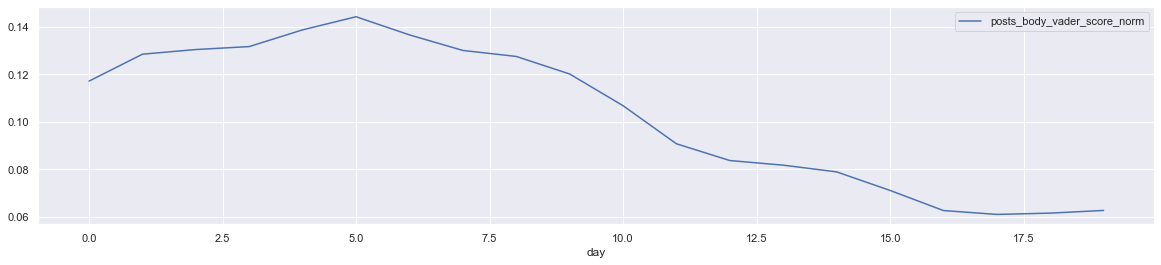

In [163]:
lagged_correlation.plot(x="day",y="posts_body_vader_score_norm", kind="line")
plt.show()

In [137]:
reddit_corpus_avg.to_csv(os.path.join("data", "reddit_corpus_avg.csv"), index=False)

In [4]:
reddit_corpus_avg= pd.read_csv(os.path.join("data", "reddit_corpus_avg.csv"))

In [138]:
reddit_corpus_norm_avg.to_csv(os.path.join("data", "reddit_corpus_norm_avg.csv"), index=False)

In [5]:
reddit_corpus_norm_avg= pd.read_csv(os.path.join("data", "reddit_corpus_norm_avg.csv"))

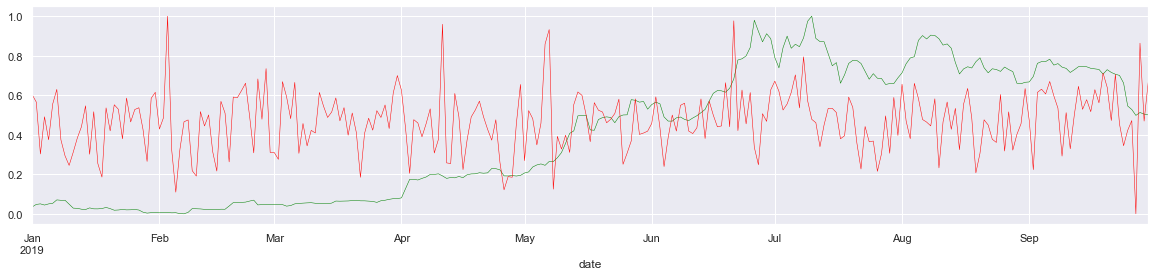

In [139]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
reddit_corpus_norm_avg['Weighted_Price_norm'].plot(linewidth=0.5, color="green");
# reddit_corpus_norm['deaths_norm'].plot(linewidth=0.5,  color="blue");
# reddit_corpus_norm['Volume_(BTC)_norm'].plot(linewidth=0.5,  color="blue");
reddit_corpus_norm_avg['posts_body_vader_score_norm'].plot(linewidth=0.5, color="red");
# reddit_corpus_norm['word_len_posts_norm'].plot(linewidth=0.5, color="red");

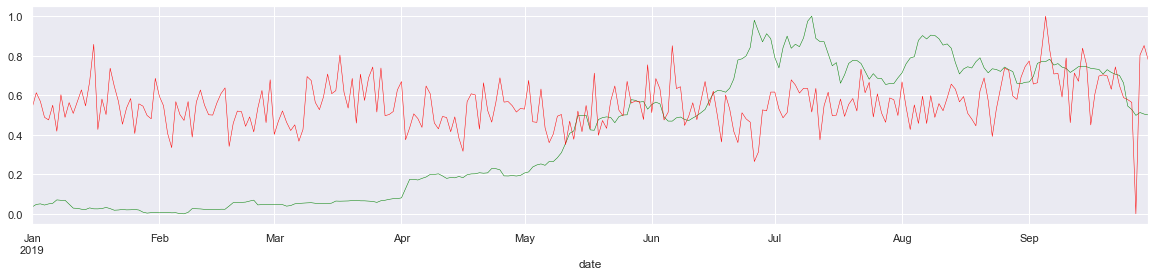

In [140]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
reddit_corpus_norm_avg['Weighted_Price_norm'].plot(linewidth=0.5, color="green");
# reddit_corpus_norm['deaths_norm'].plot(linewidth=0.5,  color="blue");
# reddit_corpus_norm['Volume_(BTC)_norm'].plot(linewidth=0.5,  color="blue");
# reddit_corpus_norm_avg['posts_body_vader_score_norm'].plot(linewidth=0.5, color="red");
reddit_corpus_norm_avg['world_len_body_norm'].plot(linewidth=0.5, color="red");

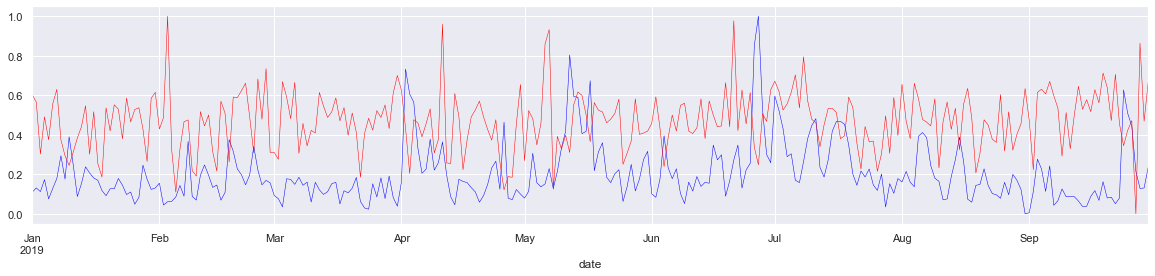

In [141]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 4)})
# reddit_corpus_norm['Weighted_Price_norm'].plot(linewidth=0.5, color="green");
# reddit_corpus_norm['deaths_norm'].plot(linewidth=0.5,  color="blue");
reddit_corpus_norm_avg['Volume_(BTC)_norm'].plot(linewidth=0.5,  color="blue");
reddit_corpus_norm_avg['posts_body_vader_score_norm'].plot(linewidth=0.5, color="red");
# reddit_corpus_norm_avg['world_len_body_norm'].plot(linewidth=0.5, color="red");

# Model selection and Model validation

# Select variables (dependent vs. independent)

In [142]:
"""
split data into train and test subsets, 80% train and 20% test
shuffle data for a better analysis

dependent variable   = Weighted_Price_norm
independent variables =posts_body_vader_score_norm
"""


'\nsplit data into train and test subsets, 80% train and 20% test\nshuffle data for a better analysis\n\ndependent variable   = Weighted_Price_norm\nindependent variables =posts_body_vader_score_norm\n'

In [143]:
X = reddit_corpus_norm_avg[['posts_body_vader_score_norm', 'world_len_body_norm']]

In [144]:
y = reddit_corpus_norm_avg[['Weighted_Price_norm']]

# Ordinary least squares Linear Regression.

In [145]:
from sklearn.linear_model import LinearRegression

In [146]:
#X = X.reshape(-1, 1)

In [147]:
reg = LinearRegression().fit(X, y)

In [148]:
reg.score(X, y)

0.029652505722086997

In [149]:
reg.coef_

array([[0.19097112, 0.35030227]])

In [150]:
reg.intercept_

array([0.11828004])

# The advantages of support vector machines

In [3]:
reddit_corpus_avg= pd.read_csv(os.path.join("data", "reddit_corpus_avg.csv"))

In [4]:
reddit_corpus_norm_avg= pd.read_csv(os.path.join("data", "reddit_corpus_norm_avg.csv"))

In [5]:
from sklearn import svm

In [6]:
reddit_corpus_norm_avg.head(4)

score_norm  world_len_body_norm  posts_body_vader_score_norm  Open_norm  \
0    0.062244             0.537649                     0.602615   0.034994   
1    0.067915             0.612576                     0.565225   0.047589   
2    0.158077             0.568380                     0.302666   0.050380   
3    0.206231             0.488242                     0.491021   0.044296   

   High_norm  Low_norm  Close_norm  Volume_(BTC)_norm  Volume_(Currency)_norm  \
0   0.035031  0.034978    0.035000           0.109463                0.025111   
1   0.047675  0.047570    0.047632           0.131134                0.033528   
2   0.050404  0.050382    0.050406           0.112412                0.027705   
3   0.044338  0.044287    0.044320           0.173052                0.046336   

   Weighted_Price_norm  
0             0.034997  
1             0.047625  
2             0.050385  
3             0.044307

In [7]:
# Add a new column for categorical data
positive = []
for score in reddit_corpus_norm_avg['posts_body_vader_score_norm']:
    if score >= 0.05:
        positive.append(2)#pozitiv
    elif score <= -0.05:
        positive.append(0)#negativ
    else:
        positive.append(1)#neutru

reddit_corpus_norm_avg['vader_class']= positive
reddit_corpus_norm_avg

score_norm  world_len_body_norm  posts_body_vader_score_norm  Open_norm  \
0      0.062244             0.537649                     0.602615   0.034994   
1      0.067915             0.612576                     0.565225   0.047589   
2      0.158077             0.568380                     0.302666   0.050380   
3      0.206231             0.488242                     0.491021   0.044296   
4      0.079263             0.475060                     0.374631   0.050158   
..          ...                  ...                          ...        ...   
268    0.143251             0.563712                     0.471602   0.527558   
269    1.000000             0.000000                     0.000000   0.497836   
270    0.028917             0.803347                     0.863437   0.512516   
271    0.030934             0.851365                     0.468937   0.504433   
272    0.005168             0.778817                     0.664644   0.500379   

     High_norm  Low_norm  Close_norm  Volume_(BTC)_norm  \
0     0.035031  0.034978    0.035000           0.109463   
1     0.047675  0.047570    0.047632           0.131134   
2     0.050404  0.050382    0.050406           0.112412   
3     0.044338  0.044287    0.044320           0.173052   
4     0.050187  0.050170    0.050192           0.075456   
..         ...       ...         ...                ...   
268   0.527671  0.527419    0.527393           0.443096   
269   0.497799  0.497853    0.497646           0.213936   
270   0.512340  0.512681    0.512294           0.128743   
271   0.504263  0.504524    0.504138           0.130669   
272   0.500346  0.500410    0.500172           0.234926   

     Volume_(Currency)_norm  Weighted_Price_norm  vader_class  
0                  0.025111             0.034997            2  
1                  0.033528             0.047625            2  
2                  0.027705             0.050385            2  
3                  0.046336             0.044307            2  
4                  0.015965             0.050177            2  
..                      ...                  ...          ...  
268                0.308659             0.527655            2  
269                0.149035             0.497931            1  
270                0.094066             0.512576            2  
271                0.094423             0.504505            2  
272                0.164170             0.500461            2  

[273 rows x 11 columns]

In [8]:
reddit_corpus_norm_avg['vader_class']

0      2
1      2
2      2
3      2
4      2
      ..
268    2
269    1
270    2
271    2
272    2
Name: vader_class, Length: 273, dtype: int64

In [38]:
y = reddit_corpus_norm_avg['vader_class'].to_list()
X = reddit_corpus_norm_avg['Weighted_Price_norm'].to_list()

In [39]:
#X = np.reshape(X, (-1, 1))

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))

In [45]:

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train,y_train)
#SVC(decision_function_shape='ovo')
clf.score(X_test,y_test)




SVC(decision_function_shape='ovo')

1.0

In [14]:
dec = clf.score(Y,X)

In [15]:
clf.decision_function_shape = "ovr"
clf.fit(X_train,y_train)
#SVC(decision_function_shape='ovo')
clf.score(X_test,y_test)


SVC()

0.9963369963369964

In [46]:
from sklearn.metrics import classification_report

In [48]:
y_pred = clf.predict(X_test)

In [50]:
target_names = ['negativ 0', 'pozitiv 2']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        82

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



In [154]:
#clf.fit(X, y)

In [155]:
#SVC()